# <font color='blue'>**LABORATORIO 2. Mejorando los resultados de clasificación sobre dataset "Adidas-Nike-Converse"**

<font color='red'>Integrantes: 
    
    Coloque los nombres completos con #ID UAO aqui (máximo 2 personas)


    Sebastian amilkar
    Milmax Duque

Adicione el código que sea necesario. No olvide comentarlo.

In [ ]:
#coloque aqui todas las librerías que usará para desarrolar este laboratorio.
#coloque aqui todas las librerías que usará para desarrolar este laboratorio.
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import random
import tensorflow.keras.models as MK
import tensorflow.keras.layers as LK
import tensorflow as tf



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/computerVision/
!mkdir BagVisualWords_classCNN
%cd BagVisualWords_classCNN
!mkdir Cv2DL_2022_clase4
%cd Cv2DL_2022_clase4/
!pwd

/content/drive/MyDrive/Colab Notebooks/computerVision
mkdir: cannot create directory ‘BagVisualWords_classCNN’: File exists
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN
mkdir: cannot create directory ‘Cv2DL_2022_clase4’: File exists
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN/Cv2DL_2022_clase4
/content/drive/MyDrive/Colab Notebooks/computerVision/BagVisualWords_classCNN/Cv2DL_2022_clase4


In [ ]:
%ls

confusion_MLP.png                nike-adidas-and-converse-imaged.zip  train/
CVwDL_2022_3_Laboratorio2.ipynb  test/


# <font color='blue'> **Defining Model Architecture and Data .**

## Meeting Data

In [ ]:
from tqdm.auto import tqdm
def load_RGB_resources(folder):
  etiquetas = os.listdir('train')
  print(etiquetas)
  images = []
  labels=[]
  for categoria in etiquetas:
    print("leyendo categoria", categoria)
    #se asigna un indice a la categoría, el cual servirá como una de las clases del vector target
    class_num = etiquetas.index(categoria)
    #folder será train o test
    ruta = os.path.join(folder,categoria)
    for img in tqdm(os.listdir(ruta)):
      # Se itera sobre la ruta Ej. train/adidas - y dentro de este folder habrá varias imágenes lo que haremos será leerlas y reedimensionarlas
      img_array = cv.imread(os.path.join(ruta, img), cv.COLOR_BGR2RGB)
      new_array = cv.resize(img_array,(224,224))
      # Se lee la imágen de la respectiva ruta, y como anteriormente se está iterando en
      #categoría, ingres la clase al vector de labels (target), y la imágen al array de imágenes
      #Se encuentran en el mismo orden por ende la clase corresponderá a la imágen Ej. Imagen de adidas - Corresponde a la clase adidas (class 0)
      images.append(new_array)
      labels.append(class_num)
  return np.array(images) , np.array(labels)

In [ ]:
x_train, y_train = load_RGB_resources('train')
x_test, y_test= load_RGB_resources('test')

x_train = x_train.reshape((x_train.shape[0],224,224,3))
x_test = x_test.reshape((x_test.shape[0],224,224,3))

print("La dimensión de los datos para entrenamiento es: ", x_train.shape)
print("La dimensión de las etiquetas para los datos de entrenamiento es: ", y_train.shape)
print("La dimensión de los datos para validacion es: ", x_test.shape)
print("La dimensión de las etiquetas para los datos de validacion es: ", y_test.shape)



['adidas', 'converse', 'nike']
leyendo categoria adidas


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoria converse


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoria nike


  0%|          | 0/237 [00:00<?, ?it/s]

['adidas', 'converse', 'nike']
leyendo categoria adidas


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoria converse


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoria nike


  0%|          | 0/38 [00:00<?, ?it/s]

La dimensión de los datos para entrenamiento es:  (711, 224, 224, 3)
La dimensión de las etiquetas para los datos de entrenamiento es:  (711,)
La dimensión de los datos para validacion es:  (114, 224, 224, 3)
La dimensión de las etiquetas para los datos de validacion es:  (114,)


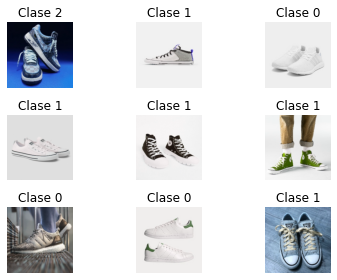

In [ ]:
#Revisando algunas imagenes del dataset y corroborar informacion
fig, ax = plt.subplots(3,3)
[axi.set_axis_off() for axi in ax.ravel()]
ax = ax.flatten()
for i in ax:
  #ax[i[]].subplot(3,3,i+1)
  num = random.randint(0, len(x_train))
  i.imshow(x_train[num], cmap='gray')
  i.set_title("Clase {}".format(y_train[num]))
plt.tight_layout()
plt.show()

## Defining Utility Functions

In [ ]:
def preprocess_data(x_train, y_train, x_test, y_test):
  
  # convert image values from integers to floats
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  
  # normalization
  x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
  X_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
  
  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  
  return x_train, y_train, x_test, y_test

In [ ]:
def summary_history(history):
  # plot loss
	plt.subplot(121)
	plt.title('Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	plt.legend(['train', 'test'], loc='upper left')
	# plot accuracy
	plt.subplot(122)
	plt.title('Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
#Este método realiza un intento de normalizacion
def preprocess_image_input(input_imgs):
  input_imgs = input_imgs.astype('float32')
  output_imgs = preprocess_input(input_imgs)
  return output_imgs

In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, epochs = 50, batch_size = 60):
   # Rescaling all training and testing data
  x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)
  x_train = preprocess_image_input(x_train)
  x_test = preprocess_image_input(x_test)

  """# Implement data augmentation
  datagen = ImageDataGenerator(horizontal_flip=True, zoom_range=0.1, rotation_range=0.2)
  it_train = datagen.flow(x_train, y_train, batch_size= batch_size)
  steps = int(x_train.shape[0] / batch_size)
  
  # Fitting the model on the training set
  history = model.fit(it_train, epochs = epochs, batch_size = batch_size,validation_data = (x_test, y_test), steps_per_epoch=steps, verbose = 1)"""
  # evaluating the model
  history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=60,verbose=1)
  _, acc = model.evaluate(x_test, y_test, verbose = 1)
  print('accuracy: %.3f' % (acc * 100.0))
  return history

In [ ]:
def cf_matrix(model,name):
  predic =model.predict(x_test)
  cm = confusion_matrix(y_test, predic.argmax(1))
  name = name
  plt.figure(figsize=(8,6))
  plt.title(name)
  sns.heatmap(cm, annot=True, fmt='g')
  plt.xticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=90)
  plt.yticks(np.arange(cm.shape[0]), ['Adidas', 'Converse', 'Nike'], rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

## Defining Architectures

### VGG16

In [ ]:
from keras.applications.vgg16 import VGG16


In [ ]:
def vgg16_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    #-------------------------------------------------------------------
    # Si se requiere regularización entonces:
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)     
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.Flatten(),
          # The first fully connected layer 
          LK.Dense(4096, activation = 'relu'),
          #DropOut
          LK.Dropout(0.3),
          # The second fully connected layer  
          LK.Dense(4096, activation = 'relu'),
          LK.Dense(3,activation='softmax')
      ])
      
      for i in range(len(modelo_vgg16.layers)):
        if isinstance(modelo_vgg16.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_vgg16.layers[i].name))
          modelo_vgg16.layers[i].kernel_regularizer = regularizer

      """for layer in modelo_vgg16.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)"""

    else:
      modelo_vgg16 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.Flatten(),
          # The first fully connected layer 
          LK.Dense(4096, activation = 'relu'),
          # The second fully connected layer  
          LK.Dense(4096, activation = 'relu'),
          LK.Dense(3,activation='softmax')
      ])
    #-----------------------------------------------------------------

    modelo_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_vgg16

In [ ]:
vgg16_model = vgg16_architecture(trainable=True, regulable=False)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### ResNet101

In [ ]:
from keras.applications.resnet import ResNet101

In [ ]:
def resnet101_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = ResNet101(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001) 
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.Flatten(),
          LK.Dropout(0.3),
          LK.Dense(128, activation='relu'),
          LK.Dense(3,activation='softmax')
      
      ])

      for i in range(len(modelo_resnet101.layers)):
        if isinstance(modelo_resnet101.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_resnet101.layers[i].name))
          modelo_resnet101.layers[i].kernel_regularizer = regularizer
    else:
      modelo_resnet101 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.Flatten(),
          LK.Dense(128, activation='relu'),
          LK.Dense(3,activation='softmax')
      
      ])

    modelo_resnet101.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_resnet101

In [ ]:
resnet101_model = resnet101_architecture(trainable=True, regulable=False)


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

### InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
def inceptionV3_architecture(trainable, regulable):
    #indclude top = False es quitar las fully connected (capas de classificación) y dejamos unicamente las de extracción de  de características que es lo que va detrás de las capas densas.
    # Tener include top = True significa tener incluso la capa de salida que es de 84 clases, las cuales no necesitamos
    modelo_base = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
    modelo_base.summary()
    # Esto significa que  entrenaremos nuevamente los pesos del estractor de características si está en True
    modelo_base.trainable = trainable
    if regulable:
      regularizer = tf.keras.regularizers.l2(0.001)
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalAveragePooling2D(),
          LK.Dense(128, activation='relu'),
          LK.Dropout(0.3),
          LK.Dense(3,activation='softmax')
      
      ])
      for i in range(len(modelo_inceptionV3.layers)):
        if isinstance(modelo_inceptionV3.layers[i], tf.keras.layers.Conv2D):
          print('Adding regularizer to layer {}'.format(modelo_inceptionV3.layers[i].name))
          modelo_inceptionV3.layers[i].kernel_regularizer = regularizer

    else:
      modelo_inceptionV3 = MK.Sequential([
          LK.UpSampling2D(size=(1,1)),
          modelo_base,
          LK.GlobalAveragePooling2D(),
          LK.Dense(128, activation='relu'),
          LK.Dense(3,activation='softmax')
      
      ])

    modelo_inceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])
    return modelo_inceptionV3

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=True, regulable=False)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

# <font color='blue'>**(50%) Parte 1. Comparando VGG16 Vs Resnet 101 Vs InceptionV3 .**

* (10%) Estudie las  3 arquitecturas propuestas. De una breve explicación sobre los pros y los contras de cada una de ellas.

* (30%)Cargue los 3 modelos haciendo uso de los modelos disponibles en Keras applications. Cambie la(s) capa(s) que sean necesaria(s) para entrenar los 3 modelos sobre el dataset generado en el Laboratorio 1. No use transfer learning de manera que permita el entrenamiento de todas las capas. Puede usar cualquier combinación de metodos de regularización con el fin de obtener el mejor resultado para usted posible.

* (10%)Visualice las metricas de accuracy, loss y confusion matrix. Analice los resultados obtenidos y escriba al menos 3 conclusiones al respecto.



## Training Architectures - No regularization

### VGG16

In [ ]:
#Coloque su código aquí
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 6/12 [==============>...............] - ETA: 11:18 - loss: 31.9961 - accuracy: 0.3500

KeyboardInterrupt: ignored

### ResNet101

In [ ]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 3/12 [======>.......................] - ETA: 11:30 - loss: 47.5010 - accuracy: 0.3500

KeyboardInterrupt: ignored

### InceptionV3

In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 5/12 [===========>..................] - ETA: 3:14 - loss: 1.0565 - accuracy: 0.5333

KeyboardInterrupt: ignored

## Visualizing - No regularization

### VGG16

In [ ]:
summary_history(vgg16_history)

In [ ]:
cf_matrix(vgg16_history,"VGG16")

### ResNet101

In [ ]:
summary_history(resnet101_history)

In [ ]:
cf_matrix(resnet101_history,"ResNet101")

### InceptionV3

In [ ]:
summary_history(inceptionV3_history)

In [ ]:
cf_matrix(inceptionV3_history,"InceptionV3")

 

##  With regularization



---



## Training Architectures -  with regularization

### VGG16

In [ ]:
vgg16_model = vgg16_architecture(trainable=True, regulable=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Coloque su código aquí
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 1/12 [=>............................] - ETA: 21:35 - loss: 2.0777 - accuracy: 0.3500

KeyboardInterrupt: ignored

### ResNet101

In [ ]:
resnet101_model = resnet101_architecture(trainable=True, regulable=True)


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 4/12 [=========>....................] - ETA: 9:49 - loss: 30.4531 - accuracy: 0.3167 

KeyboardInterrupt: ignored

### InceptionV3

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=True, regulable=True)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 4/12 [=========>....................] - ETA: 4:00 - loss: 1.2914 - accuracy: 0.4458

KeyboardInterrupt: ignored

## Visualizing - with regularization

### VGG16

In [ ]:
summary_history(vgg16_history)

In [ ]:
cf_matrix(vgg16_history,"VGG16")

### ResNet101

In [ ]:
summary_history(resnet101_history)

In [ ]:
cf_matrix(resnet101_history,"ResNet101")

### InceptionV3

In [ ]:
summary_history(inceptionV3_history)

In [ ]:
cf_matrix(inceptionV3_history,"InceptionV3")

## <font color='red'>**Utilice este espacio para colocar su análisis (imagenes, tablas, conclusiones, etc.)**

# <font color='blue'>**(50%) Parte 2. Usando Transfer Learning + Regularization**

* (15%) Entrene los 3 modelos originales usando solo transfer learning. Visualice las curvas de Accuracy, Loss y Confusion Matrix

* (25%) Entrene los 3 modelos usando transfer learning + Regularización (considere combinar más de un método). Visualice las curvas de Accuracy, Loss y Confusion Matrix

* (10%)Analice los resultados obtenidos y escriba al menos 3 conclusiones al respecto. 




## Training/visualizing - Transferlearning

### **Training Architectures - Transfer learning - VGG16**

### Training - VGG16- Transfer

In [ ]:
vgg16_model = vgg16_architecture(trainable=False, regulable=False)

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 2/12 [====>.........................] - ETA: 5:11 - loss: 44.7901 - accuracy: 0.3000

KeyboardInterrupt: ignored

### Visualizing - VGG16- Transfer

In [ ]:
summary_history(vgg16_history)

In [ ]:
cf_matrix(vgg16_history,"VGG16")



---



### **Training Architectures - Transfer learning - ResNet101**

### Training - ResNet101 - Transfer

In [ ]:
resnet101_model = resnet101_architecture(trainable=False, regulable=False)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 6/12 [==============>...............] - ETA: 1:42 - loss: 15.9173 - accuracy: 0.3306

KeyboardInterrupt: ignored

### Visualizing - ResNet101 - Transfer

In [ ]:
summary_history(resnet101_history)

In [ ]:
cf_matrix(resnet101_history,"ResNet101")

### **Training Architectures - Transfer learning - IncenptionV3**

### Training - Incenption V3 - Transfer

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=False, regulable=False)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test)

Epoch 1/5
12/12 [==============================] - 110s 8s/step - loss: 74.9780 - accuracy: 0.3488 - val_loss: 15.8662 - val_accuracy: 0.3246
Epoch 2/5
 1/12 [=>............................] - ETA: 1:07 - loss: 15.5226 - accuracy: 0.3667

KeyboardInterrupt: ignored

### Visualizing - InceptionV3 - Transfer

In [ ]:
summary_history(inceptionV3_history)

In [ ]:
cf_matrix(inceptionV3_history,"InceptionV3")

## Training/visualizing - Transferlearning + Regularization

### **Training Architectures - Transfer learning - VGG16 + Regularization**

### Training - VGG16- Transfer + Regularization

In [ ]:
vgg16_model = vgg16_architecture(trainable=False, regulable=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg16_history = train_model(vgg16_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 1/12 [=>............................] - ETA: 7:08 - loss: 1.1925 - accuracy: 0.4667

KeyboardInterrupt: ignored

### Visualizing - VGG16- Transfer + Regularization

In [ ]:
summary_history(vgg16_history)

In [ ]:
cf_matrix(vgg16_history,"VGG16")



---



### **Training Architectures - Transfer learning - ResNet101 + Regularization**

### Training - ResNet101 - Transfer + Regularization

In [ ]:
resnet101_model = resnet101_architecture(trainable=False, regulable=True)

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
resnet101_history = train_model(resnet101_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 6/12 [==============>...............] - ETA: 1:42 - loss: 14.2825 - accuracy: 0.3194

KeyboardInterrupt: ignored

### Visualizing - ResNet101 - Transfer + Regularization

In [ ]:
summary_history(resnet101_history)

In [ ]:
cf_matrix(resnet101_history,"ResNet101")

### **Training Architectures - Transfer learning - IncenptionV3 + Regularization**

### Training - Incenption V3 - Transfer + Regularization

In [ ]:
inceptionV3_model = inceptionV3_architecture(trainable=False, regulable=True)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 111, 111, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 111, 111, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                                                      

In [ ]:
inceptionV3_history = train_model(inceptionV3_model, x_train, y_train, x_test, y_test)

Epoch 1/5
 6/12 [==============>...............] - ETA: 41s - loss: 94.7463 - accuracy: 0.3278 

KeyboardInterrupt: ignored

### Visualizing - InceptionV3 - Transfer + Regularization

In [ ]:
summary_history(inceptionV3_history)

In [ ]:
cf_matrix(inceptionV3_history,"InceptionV3")

## <font color='red'>**Utilice este espacio para colocar su análisis (imagenes, tablas, conclusiones, etc.)**